**Molecular Dynamics simulation routine:**

this is some text that explains stuff you do.

* Import external libraries:

In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

import copy
import numpy as np
import scipy as scy

* Creating a particle class:

In [2]:
class Particle:
    def __init__(self, r, x, y, vx, vy):
        self.r = r
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
        
    def __repr__(self):
        return str("This is a particle at %0.2f, %0.2f with v=%0.2f,%0.2f" % (self.x,self.y,self.vx,self.vy))

* Defining the box:

In [3]:
box_size_x = 20
box_size_y = 20

box = [box_size_x,box_size_y]

In [4]:
number_of_particles = 20

* Initialize velocities:

In [5]:
vel = np.ones(number_of_particles)*0.5
angles = np.random.uniform(0,2*np.pi,number_of_particles)


* Initialize position:

In [6]:
x_rand = np.random.randint(1,box[0]-1,number_of_particles)
y_rand = np.random.randint(1,box[1]-1,number_of_particles)


* Setting up the particle:

In [7]:
particles = []
for i in range(number_of_particles):
    particles.append(Particle(0.5,x_rand[i],y_rand[i],np.sin(angles[i])*vel[i],np.cos(angles[i])*vel[i]))


* Defining simulation step numbers

In [8]:
steps = 300

* initialize trajectory:

In [9]:
data_traj = np.zeros((number_of_particles,4,steps))
data_traj.shape

(20, 4, 300)

* define time integrator for numerical, stepwise solution of equation of motion with a discrete time step $dt$:

In [10]:
def move_unbound(p,dt):
    p.x = np.mod(p.x + p.vx*dt,box_size_x)
    p.y = np.mod(p.y + p.vy*dt,box_size_y)
    return p

The following algorithm works by checkin pariwise collisions. If there is a collision, defined by any overlap of two particles, the particles travel back in time, so that they are just touching. Then the new velocities are calculated whilst turning the coordinate system, to provide for easier calculation. Then the time is unwound forwards, considering the new velocities, so that each particle has the same time passed in one calculation step. When a particle is in the boundary of the box (close to 0 position on either axis), it is additionally checked for any particles that are on the opposite side of the box.

In [19]:
def collision(particles,data_traj,step, dt,i,j):
    distance_vector = np.array([particles[j].x-particles[i].x,particles[j].y-particles[i].y])# von i nach j
    distance = np.sqrt(np.abs(distance_vector[0])**2+np.abs(distance_vector[1])**2)
    R = particles[i].r+particles[j].r
    if distance<R:
        #print(step)
        print(particles[i],particles[j],'collided with a distance of ', distance)
        # angle between x-axis and line between particles
        phi = np.arctan((particles[j].y - particles[i].y)/(particles[j].x - particles[i].x))
        
        # in time
        # defining re-used variables
        v_x = particles[i].vx-particles[j].vx
        v_y = particles[i].vy-particles[j].vy

        r_x = particles[j].x-particles[i].x
        r_y = particles[j].y-particles[i].y

        #calculating the time needed to travel back in two steps:
        sqrt = 2*np.sqrt((r_x*v_x+r_y*v_y)**2-(v_x**2+v_y**2)*(r_x**2+r_y**2-R**2))
        
        delta_t = -1*(-2*(r_x*v_x+r_y*v_y) + sqrt)/(2*(v_x**2+v_y**2))
        
        #the equations have to solutions, we want the negative solution, for backwards time-travel
        if delta_t > 0:
            delta_t = -1*(-2*(r_x*v_x+r_y*v_y) - sqrt)/(2*(v_x**2+v_y**2))
        
        

        #delta_t = delta_t

        # rewind time to just outside of the collision
        particles[i].x = particles[i].x + particles[i].vx*delta_t
        particles[i].y = particles[i].y + particles[i].vy*delta_t
        particles[j].x = particles[j].x + particles[j].vx*delta_t
        particles[j].y = particles[j].y + particles[j].vy*delta_t

        #debugging
        distance = np.sqrt(np.abs(particles[i].x-particles[j].x)**2+np.abs(particles[i].y-particles[j].y)**2)
        #print(particles[i],particles[j],'collided with a distance of ', distance)

        #used chatGPT for debugging
        # change the velocities

        # only calculate once, used multiple times
        sin_phi = np.sin(phi)
        cos_phi = np.cos(phi)

        # Get the velocities of particles i and j as variables
        v1x, v1y = particles[i].vx, particles[i].vy
        v2x, v2y = particles[j].vx, particles[j].vy

        # Calculate the updated velocities using the provided formulas: https://hermann-baum.de/elastischer_stoss/
        # the tangental part stays the same, the normal part changes. This is done in transformed coordinates and then transformed directly back
        new_v1x = (v1x * sin_phi - v1y * cos_phi) * sin_phi + (v2x * cos_phi + v2y * sin_phi) * cos_phi
        new_v1y = (-v1x * sin_phi + v1y * cos_phi) * cos_phi + (v2x * cos_phi + v2y * sin_phi) * sin_phi
        new_v2x = (v2x * sin_phi - v2y * cos_phi) * sin_phi + (v1x * cos_phi + v1y * sin_phi) * cos_phi
        new_v2y = (-v2x * sin_phi + v2y * cos_phi) * cos_phi + (v1x * cos_phi + v1y * sin_phi) * sin_phi

        # Update the particles' velocities
        particles[i].vx, particles[i].vy = new_v1x, new_v1y
        particles[j].vx, particles[j].vy = new_v2x, new_v2y
        
        # just for debugging
        distance = np.sqrt(np.abs(particles[i].x-particles[j].x)**2+np.abs(particles[i].y-particles[j].y)**2)
        #print(particles[i],particles[j],'collided with a distance of ', distance)

        # finish this time_step, that was rewound previously and open the boundaries again with np.mod
        particles[i].x = np.mod(particles[i].x - particles[i].vx*delta_t,box_size_x)
        particles[i].y = np.mod(particles[i].y - particles[i].vy*delta_t,box_size_y)
        particles[j].x = np.mod(particles[j].x - particles[j].vx*delta_t,box_size_x)
        particles[j].y = np.mod(particles[j].y - particles[j].vy*delta_t,box_size_y)
        # debugging
        distance = np.sqrt(np.abs(particles[i].x-particles[j].x)**2+np.abs(particles[i].y-particles[j].y)**2)
        #print(particles[i],particles[j],'collided with a distance of ', distance)

def collide_border(particles,data_traj,step, dt,i,x):
    # set particle to the opposite box
    if x:
        pos_x = particles[i].x+box_size_x
    else:
        pos_y = particles[i].y+box_size_y
    # check for collisions
    for j in range(len(particles)):
        if i < j:
            collision(particles,data_traj,step, dt, i, j)
            

def collide_boundary(particles,data_traj,step, dt):
    #run through all pairwise possible interactions and check collisions
    for i in range(len(particles)):
        for j in range(len(particles)):
            if i < j:
                collision(particles,data_traj,step, dt, i, j)
        # account for edge cases
        if particles[i].x<particles[i].r:
            collide_border(particles,data_traj,step, dt,i,True)
        if particles[i].y<particles[i].r:
            collide_border(particles,data_traj,step, dt,i,False)
                    

The actual integration happens here. Everything is saved to the predefined data_traj-array

In [20]:
dt = 1
for i in range(steps):
    for j in range(number_of_particles):
        #move(p1,1)
        #reflect(p1)
        move_unbound(particles[j],dt)
    collide_boundary(particles,data_traj,i,dt)
    for j in range(number_of_particles):
        data_traj[j,:,i] = [particles[j].x, particles[j].y, particles[j].vx, particles[j].vy]
        

This is a particle at 1.39, 6.42 with v=-0.39,-0.09 This is a particle at 2.28, 6.83 with v=-0.44,-0.73 collided with a distance of  0.9821191253417714
This is a particle at 1.67, 4.44 with v=-0.16,-0.60 This is a particle at 1.71, 4.53 with v=0.09,0.49 collided with a distance of  0.09676235847803362
This is a particle at 13.90, 1.90 with v=-0.58,0.01 This is a particle at 13.68, 1.66 with v=0.67,0.61 collided with a distance of  0.329139181257079
This is a particle at 18.02, 5.31 with v=-0.67,-0.22 This is a particle at 17.88, 6.26 with v=0.01,0.08 collided with a distance of  0.9637640557658367
This is a particle at 5.46, 15.38 with v=-0.04,-0.05 This is a particle at 6.15, 14.83 with v=-0.28,-0.06 collided with a distance of  0.8777368688196746
This is a particle at 17.30, 5.44 with v=-0.70,-0.03 This is a particle at 17.95, 5.98 with v=0.04,-0.12 collided with a distance of  0.8430477139063342
This is a particle at 4.32, 8.42 with v=-0.54,-0.42 This is a particle at 3.69, 7.91 wit

In [21]:
#data_traj

* Plotting trajectory with Matplotlib:

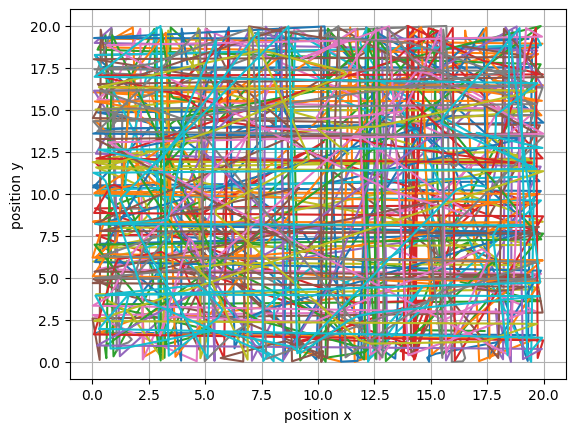

In [22]:
for data_traj_j in data_traj:
    plt.plot(data_traj_j[0],data_traj_j[1],'-')
plt.xlabel('position x')
plt.ylabel('position y')

plt.grid()
plt.show()

**Animate trajectory:**

* Set up the figure, the axis, and the plot element we want to animate

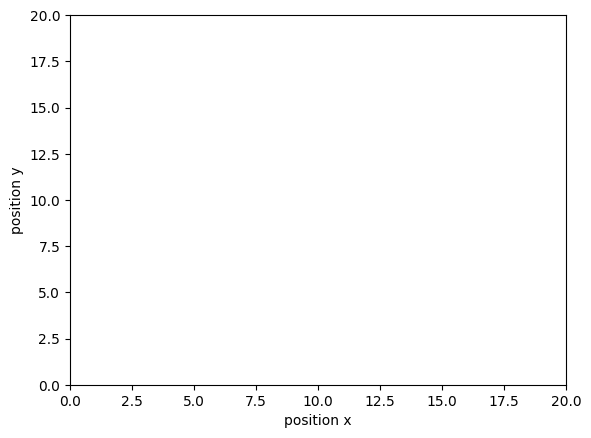

In [23]:
fig, ax = plt.subplots()

ax.set_xlim((0, box[0]))
ax.set_ylim((0, box[1]))

plt.xlabel('position x')
plt.ylabel('position y')

dot, = ax.plot([], [], 'bo', ms=5.0)


* initialization function: plot the background of each frame

In [24]:
def init():
    dot.set_data([], [])
    return (dot,)

In [25]:
data_traj[:,0,1]

array([17.80196039,  1.14236375, 16.80173727,  9.70379141, 13.00824017,
       15.76471086, 13.61330558, 18.52080792,  1.37427592, 10.41196839,
        4.18185594,  7.4723503 , 17.81822047,  5.6806655 ,  7.5440389 ,
       17.03109656, 10.31031303,  2.29959109,  7.661663  ,  1.35439163])

* animation function. This is called sequentially

In [26]:
def animate(i):
    x = data_traj[:,0,i]
    y = data_traj[:,1,i]
    dot.set_data(x, y)
    return (dot,)

* call the animator. blit=True means only re-draw the parts that have changed.

In [27]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=steps, interval=60, blit=True)

In [28]:
HTML(anim.to_html5_video())

**Histogramming:**

KeyboardInterrupt: 

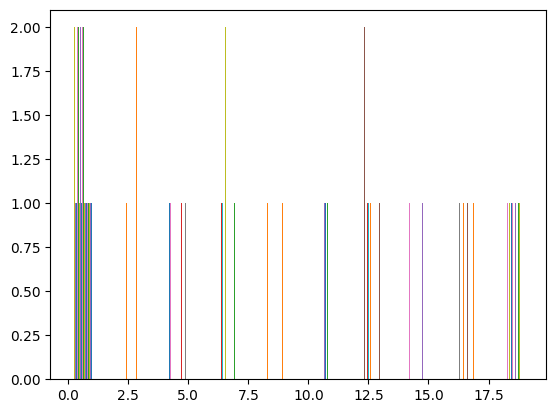

In [173]:
plt.hist(data_traj[0],range=(0,box[0]),bins=10)
plt.xlabel('position x')
plt.ylabel('occupancy')
plt.show()

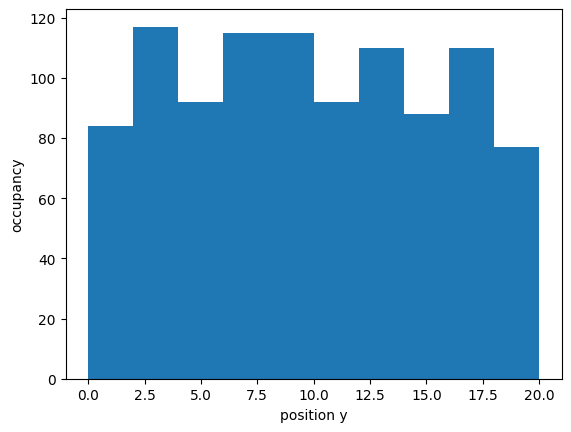

In [22]:
plt.hist(data_traj[1],range=(0,box[1]),bins=10)
plt.xlabel('position y')
plt.ylabel('occupancy')
plt.show()

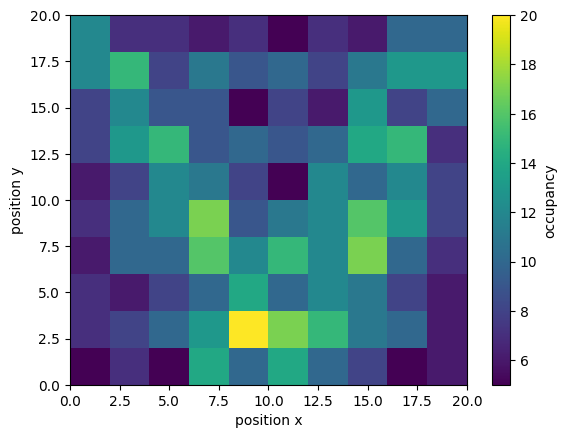

In [23]:
plt.hist2d(data_traj[0], data_traj[1], range=[[0,box[0]],[0,box[1]]], bins=10)
plt.xlabel('position x')
plt.ylabel('position y')
plt.colorbar().set_label('occupancy')
plt.show()

**Interpretation:**
* in the reduced data projection, the occupancy of each bin seems even and well-distributed
* in the full dimensional projection, it can be seen easily that the box is **not** fully sampled, large undersampled patches present
* *data dimensionality reduction always brings the danger of wrong projection!*

**Solution for improvements:**
* enhance sampling by
    * prolong the simulation
    * increase the time step
* *Caveat: all solutions come with problems like increased computational cost or sampling errors!*